# Results

In [35]:
library('ggplot2')
source('get_expected_pval_and_equiv_z.R')
source('multiplot.R')
source('plot_lib.R')

#### Load data from the CSV files

##### One-sample

In [36]:
allsimudat_btw0 <- load_data_from_csv('^test1_.*btw0_.*')
allsimudat_btw1 <- load_data_from_csv('^test1_.*btw1_.*')
allsimudat <- rbind(allsimudat_btw0, allsimudat_btw1)

##### Two-sample

In [37]:
allsimudat2_btw0 <- load_data_from_csv('^test2_.*btw0_.*')
allsimudat2_btw1 <- load_data_from_csv('^test2_.*btw1_.*')
allsimudat2 <- rbind(allsimudat2_btw0, allsimudat2_btw1)

In [38]:
unique(allsimudat2_btw0$glm)

[1] 2

##### Unbalanced two-sample

In [39]:
allsimudat3_btw0 <- load_data_from_csv('^test3_.*btw0_.*')
allsimudat3_btw1 <- load_data_from_csv('^test3_.*btw1_.*')
allsimudat3 <- rbind(allsimudat3_btw0, allsimudat3_btw1)

### 1. Robustness to units mismatch

We look how contrast-based methods are affected by the units issue.

In [40]:
con_methods <- c("megaMFX","megaRFX","permutCon", "megaFFX_FSL")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% con_methods)
con_data_2 <- subset(allsimudat2, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)
con_data_3 <- subset(allsimudat3, is.finite(expectedz) & expectedz>0 & methods %in% con_methods)

##### Plots

###### Units mismtach

We look at the best case scenario for each contrast-based method:
 - MFX GLM: τ2 ≠ 0 -> τ2 = 1
 - RFX GLM: σ2<<τ2 or σ2/n constant for all studies -> σ2=1/2
 - Contrast Permutation: anything
 - FFX GLM: τ2 = 0

In [41]:
best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==25)
best_con_data_2 <- subset(con_data_2, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)
best_con_data_3 <- subset(con_data_3, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Within==5)  | 
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon"))
    ) & nStudies==50)

#### One-sample tests

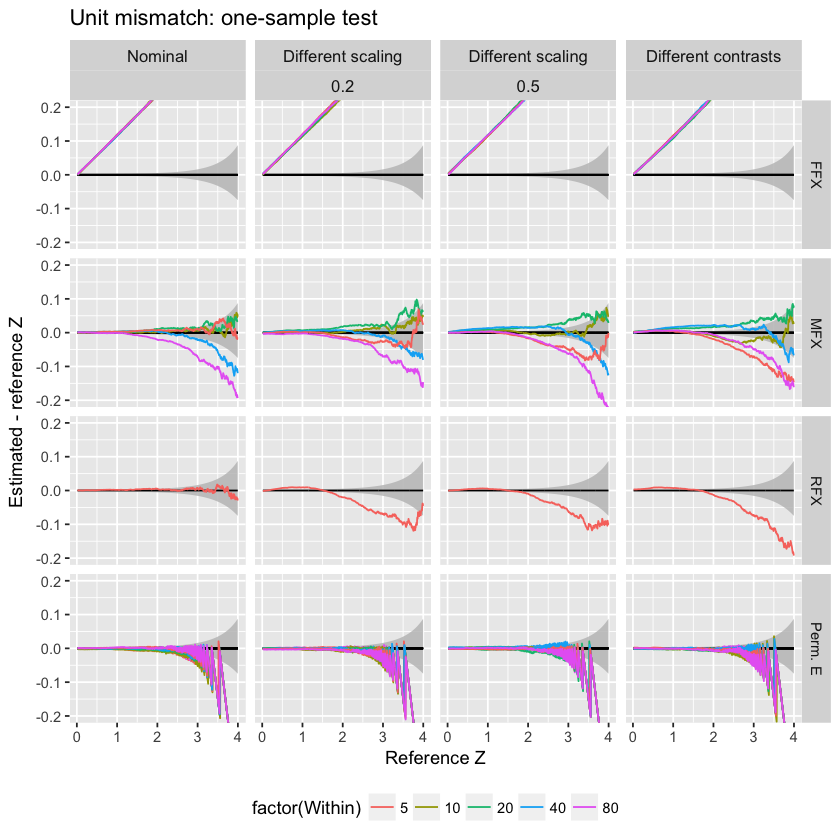

In [42]:
source('plot_lib.R')
# Note for RFX we only keep btw=1 for display purposes (results with btw=0 are very similar)
# Also we only keep z>4 (to avoid very variable tail affecting ylim)
plot_unit_mismatch(
    subset(best_con_data_1, 
           ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX"))) & 
           expectedz<4
          ), 
    'one-sample test', mult=FALSE, single=TRUE, lim=0.2, 
    filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test1"))

#### Two-sample tests

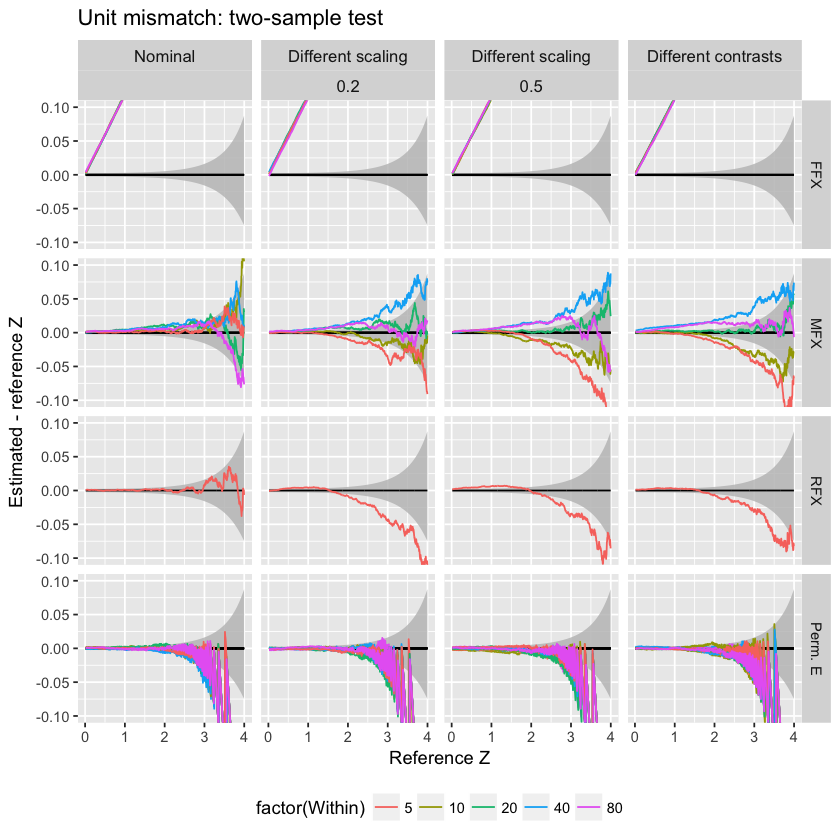

In [43]:
source('plot_lib.R')
plot_unit_mismatch(
    subset(best_con_data_2,            
           ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX"))) & 
           expectedz<4),
    'two-sample test', mult=FALSE, single=TRUE, lim=0.1, 
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test2"))

#### Unbalanced two-sample tests)

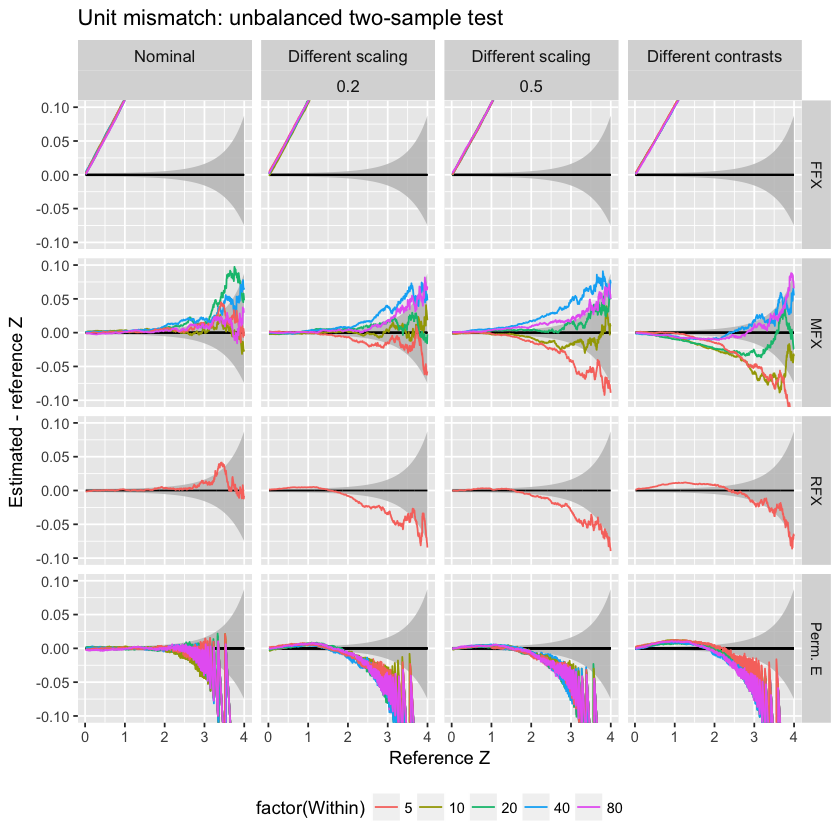

In [44]:
plot_unit_mismatch(
    subset(best_con_data_3, 
          ((methods %in% c("megaRFX") & Between==1) | !(methods %in% c("megaRFX"))) & 
           expectedz<4),
    'unbalanced two-sample test', mult=FALSE, single=TRUE, lim=0.1,
     filename=file.path("..", "..", "..", "..", "zmeta_paper", "figures", "unitmimatch_test3"))

### 1. Robustness to units mismatch